In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table

%matplotlib widget
from tqdm import trange

import physicsConsts as c
from simulation_functions import get_AM3, blastwave, powerlaw_array
from plotting_functions import plot_spectrum, plot_coolingtimes, Eobs_av, dens2flux_av
import setFigureConfig as sfc

from colorschemes import get_comp_cols
compcols = get_comp_cols()


# set up AM3

In [3]:
am3 = get_AM3(exp=1, hadronic=1, qsyn=0) # expansion needed for time dependent method
am3.init_kernels()

init. AM3 kernels:
AM3 has the following switches (at step: 0)
estimate maximum energies: 0
parse sed components: 1
escape: 1
expansion: 1
adiabatic: 1
synchrotron:
  e+/-: 1  (em..: 1, cool.: 1)
  protons:1  (em..: 1, cool.: 1)
  pions:1  (em..: 1, cool.: 1)
  muons:1  (em..: 1, cool.: 1)
  syn-self-abs.:1
  e+/- quantum-syn.:0
inv. Compton:
  e+/-: 1  (em.. : 1, cool.: 1 (continuous))
  photon loss due to upscattering: 1
  protons:1  (em.. (step approx.): 1, no cooling)
  pions:1  (em.. (step approx.): 1, cont. cool.: 1)
  muons:1  (em.. (step approx.): 1, cont. cool.: 1)
pair prod. (gamma+gamma->e+e)1  (photon loss.: 1, e+/- source (feedback): 1(opt. 14-bin kernel))
'hadronic' processes (below): 1
 Pion decay: 1 Muon decay:1)
proton Bethe-Heitler: 1  (em..: 1, cool.: 1)
proton photo-pion: 1  (em..: 1, cool.: 1, photon loss: 1)
proton p-p: 1  (em..: 1 , cool.: 1)

AM3 params (comoving):
escape_timescale: 1e+06 s
  with fractions: (protons: 1, neutrons: 1, pions: 1, muons: 1, neutrino

In [4]:
# short cuts for energy grids
Ee_eV = am3.get_egrid_lep()
Ee_erg = Ee_eV * c.eV2erg
Eg_eV = am3.get_egrid_photons()
Eg_erg = Eg_eV * c.eV2erg
Ep_eV = am3.get_egrid_had()
Ep_erg = Ep_eV * c.eV2erg
En_eV = am3.get_egrid_neutrinos()
En_erg = En_eV * c.eV2erg

## set parameters

In [5]:
z = 0.1
Gamma = 10**1.3667
n = 1e3 # cm^-3
t_obs = 1e3 # s
epsilon_B = 10**-4.5
epsilon_e = 10**-6.5
epsilon_p = 10**0
p = 2.1
Emin = 10**9 # eV
eta = 3
Ntdyn = 5
fdt = 1e-2 # time step as a fraction of dynamical time
Gamma

23.264836245182433

## run simulation

In [6]:
am3.clear_particle_densities()
am3.set_electron_accel_factor(eta)
am3.set_proton_accel_factor(eta)
am3.set_escape_fraction_charged_particles(0)
am3.set_escape_fraction_neutral_particles(1)

B_last = 0 # updates magnetic field for sure

N_evo = int(Ntdyn/fdt)

for i in trange(N_evo):
    # log time steps
    t_obs_evo = (1-fdt)**(N_evo-i -1) * t_obs
    t_dyn, n_target, p_ram_eval, B = blastwave(
        t_obs_evo, Gamma, n, t_obs, epsilon_B)

    # update parameters
    am3.set_escape_timescale(t_dyn)
    am3.set_expansion_timescale(t_dyn)
    am3.set_solver_time_step(fdt * t_dyn)
    am3.set_pp_target_proton_density(n_target)
    am3.set_mag_field(B)

    # estimate max. energy
    if i>0:
        am3.estimate_max_electron_energy()
        Eemax = am3.get_estimated_electron_emax()
        am3.estimate_max_proton_energy()
        Epmax = am3.get_estimated_proton_emax()
    else: # use small value for first step
        Eemax = 10*Emin
        Epmax = 10*Emin
    # update injection spectra
    am3.set_injection_rate_electrons(
        Ee_erg*powerlaw_array(
            Ee_erg, Emin*c.eV2erg, Eemax*c.eV2erg, p, epsilon_e*p_ram_eval / t_dyn))
    am3.set_injection_rate_protons(
        Ep_erg*powerlaw_array(
            Ep_erg, Emin*c.eV2erg, Epmax*c.eV2erg, p, epsilon_p*p_ram_eval / t_dyn))
    
    am3.evolve_step()


100%|██████████| 500/500 [00:37<00:00, 13.49it/s]


In [7]:
# save neutrinos
Enobs_eV = Eobs_av(En_eV, z, Gamma)
Ftot = dens2flux_av(am3.get_neutrinos()*En_erg, t_obs, z, Gamma)

np.savetxt("pp-cascade-neutrinos.txt", np.array([Enobs_eV, Ftot]).T, delimiter=",", header="E[eV], EF_E [erg/cm^3s]")

# plots

/lustre/fs23/group/that/mklinger/conda/miniconda3/envs/am3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


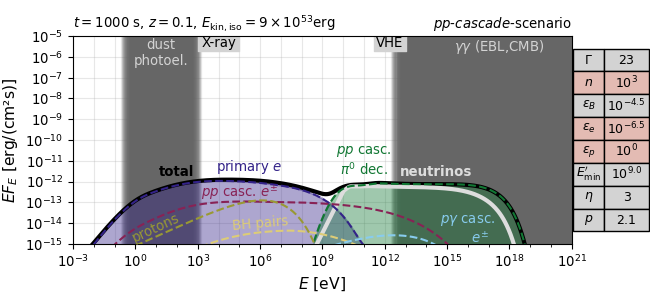

In [8]:
%matplotlib widget
sfc.fullWidth(aspectRatio=0.47, alpha=0.8)
fig, (ax, axtbl) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [12, 1], "wspace":-.01})
ind = -1
ax = plot_spectrum(
    ax, z, Gamma, t_obs, Eg_eV=Eg_eV, En_eV=En_eV, 
    E2dN_dE_tot_gamma=Eg_erg*am3.get_photons(), 
    E2dN_dE_tot_nu=En_erg*am3.get_neutrinos(),
    components=[
        [Eg_erg*am3.get_photons_injected_electrons_syn_compton(), compcols["in"], True, 0, "--", "inj", 1.5],
        [Eg_erg*am3.get_photons_annihilation_pairs_syn_compton(), compcols["pair"], False, 1, "--", "pair", 1.5],
        [Eg_erg*am3.get_photons_bethe_heitler_pairs_syn_compton(), compcols["bh"], False, 1, "--", "BH", 1.5],
        [Eg_erg*am3.get_photons_proton_proton_pairs_syn_compton(), compcols["pp"], False, 1, "--", "pp", 1.5],
        [Eg_erg*am3.get_photons_photo_pion_pairs_syn_compton(), compcols["pg"], False, 1, "--", "pg", 1.5],
        [Eg_erg*am3.get_photons_protons_syn_compton(), compcols["p"], False, 1, "--", "p", 1.5],
        [Eg_erg*am3.get_photons_pions_syn_compton(), compcols["pi"], False, 1, "--", "pi", 1.5],
        [Eg_erg*am3.get_photons_muons_syn_compton(), compcols["mu"], False, 1, "--", "mu", 1.5],
        [Eg_erg*am3.get_photons_pi0_decay(), compcols["pi0"], True, 0, "--", "pi0_pp", 1.5],
    ], ylim=[1e-15, 1e-5], xlim=[1e-3, 1e21], cgrey="#666666", col_tot=compcols["total"], col_nu=compcols["nu"]
)

ax.text(3e5, 5e-12, r"primary $e$", color=compcols["in"], va="center", ha="center", zorder=100, rotation=0)
ax.text(1e1, 6e-15, r"protons", color=compcols["p"], va="center", ha="center", zorder=100, rotation=25)
ax.text(1e6, 1e-14, r"BH pairs", color=compcols["bh"], va="center", ha="center", zorder=100, rotation=5)
ax.text(1e5, 3e-13, r"$pp$ casc. $e^{\pm}$", color=compcols["pp"], va="center", ha="center", zorder=100, rotation=0)
ax.text(1e16, 5e-15, r"$p\gamma$ casc." +"\n      " + r"$e^{\pm}$", color=compcols["pg"], va="center", ha="center", zorder=100, rotation=0)
ax.text(1e11, 1e-11, r"$pp$ casc."+"\n$\pi^0$ dec.", color=compcols["pi0"], va="center", ha="center", zorder=100, rotation=0)
# ax.text(1e-2, 2e-13, r" $\gamma\gamma\to e^{\pm}$", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=35)
ax.text(1e2, 3e-12, "total", color="k", va="center", ha="center", weight="bold")
ax.text(3e14, 3e-12, "neutrinos", color=compcols["nu"], va="center", ha="center", weight="bold", zorder=100)
# ax.text(2e14, 3e-12, r" $\gamma\gamma\to e^{\pm}$ IC.", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=-50)
# leg = ax.legend(framealpha=1, loc="lower center", handlelength=3)
# leg.set_zorder(100)
ax.set_title(r"$pp$-$cascade$-scenario", loc="right")
table_data = [
    [r"$\Gamma$",r"$n$",r"$\varepsilon_B$",r"$\varepsilon_e$", r"$\varepsilon_p$", r"$E_\mathrm{min}'$",r"$\eta$", r"$p$"],
    [int(Gamma)] + 
    [r"$10^{%g}$"% np.log10(x) for x in [n]]+ 
    [r"$10^{%g}$"% np.log10(x) for x in [epsilon_B, epsilon_e, epsilon_p]]+ 
    [r"$10^{%.1f}$"% np.log10(x) for x in [Emin]] + [int(eta), p]
]

ax.set_title(ax.get_title(loc="left")+ r", $E_\mathrm{kin,iso}=9\times 10^{53} \mathrm{erg}$", loc="left")

# Create a table
table = Table(axtbl, loc='center right')

# Add cells to the table
for i, row in enumerate(table_data):
    for j, cell in enumerate(row):
        if j==1 or j==4 or j==3:
            tablecol="#e3bbb3"
        else:
            tablecol = "lightgrey"
        table.add_cell(
            j, i, width=0.65 +i*0.3, height=0.11, text=cell, loc='center', 
            facecolor=tablecol)


axtbl.axis("off")
# Adjust the appearance of the table
table.auto_set_font_size(False)
table.set_fontsize(9)

# Add the table to the subplot
axtbl.add_table(table)


plt.subplots_adjust(left=0.06, right=1, bottom=0.2)
fig.tight_layout()
sfc.saveFigure(fig, f"pp-cascade-spectrum-photons", dpi=500)

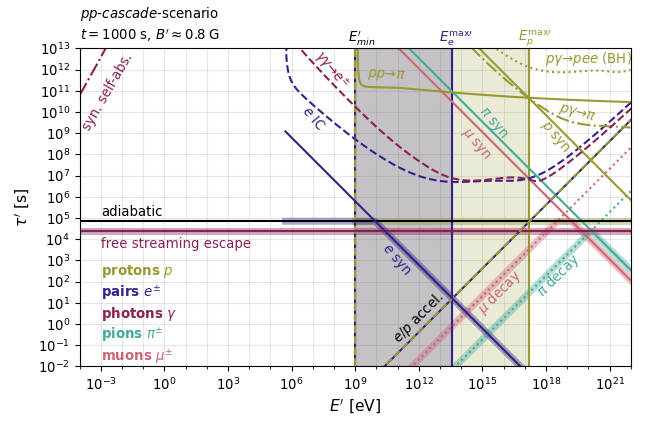

In [9]:
%matplotlib widget
sfc.fullWidth(aspectRatio=0.65, alpha=0.8)
fig, ax = plt.subplots() #figsize=(6,3))
cgamma = compcols["pp"]

inds_p = (Ep_eV<1e100)# am3.get_estimated_proton_emax())
tdom_p = np.minimum(am3.get_t_proton_adiabatic(), am3.get_t_proton_syn())
ax.loglog(Ep_eV[inds_p], tdom_p[inds_p], alpha=0.4, color=compcols["p"], lw=5)

tdom_mu = np.minimum(
    np.minimum(am3.get_t_proton_adiabatic(), am3.get_t_muon_syn()),
    am3.get_t_muon_decay())
ax.loglog(Ep_eV[inds_p], tdom_mu[inds_p], alpha=0.4, color=compcols["mu"], lw=5)

tdom_pi = np.minimum(
    np.minimum(am3.get_t_proton_adiabatic(), am3.get_t_pion_syn()),
    am3.get_t_pion_decay())
ax.loglog(Ep_eV[inds_p], tdom_pi[inds_p], alpha=0.4, color=compcols["pi"], lw=5)

inds_e = (Ee_eV< 1e100) #am3.get_estimated_proton_emax())
tdom_e = np.minimum(am3.get_t_pair_adiabatic(), am3.get_t_pair_syn())
ax.loglog(Ee_eV[inds_e], tdom_e[inds_e], alpha=0.4, color=compcols["in"], lw=5)

tdom_g = np.minimum(am3.get_t_photon_escape(), am3.get_t_photon_annihilation())
ax.loglog(Eg_eV, tdom_g, alpha=0.4, color=cgamma, lw=5)


ax = plot_coolingtimes(
    ax, Ep_eV, Ee_eV, Eg_eV, 0, Emin, Emin,
    [am3.get_t_proton_syn()], [am3.get_t_proton_adiabatic()],
    [am3.get_t_proton_acceleration()], [am3.get_t_proton_compton()],
    [am3.get_t_proton_bethe_heitler()], [am3.get_t_proton_photopion()],
    [am3.get_t_proton_proton_proton()], [am3.get_t_pair_syn()],
    [am3.get_t_pair_compton()], [am3.get_t_pair_acceleration()],
    [am3.get_t_photon_escape()], [am3.get_t_photon_annihilation()],
    [am3.get_t_photon_ssa()], 
    am3.get_t_pion_decay(), am3.get_t_muon_decay(), leptonic=False,
    ylim=[1e-2, 1e13], xlim=[1e-4, 1e22], cel=compcols["in"], cproton=compcols["p"],
    cpion=compcols["pi"], cmuon=compcols["mu"], cgamma=cgamma
)

ax.text(2e-3, 9e10, r"syn. self-abs.", color=cgamma, va="center", ha="center", zorder=100, rotation=60)
ax.text(8e7, 1e12, r"$\gamma\gamma \to e^{\pm}$", color=cgamma, va="center", ha="center", zorder=100, rotation=-50)
ax.text(1e-3, 6e3, r"free streaming escape", color=cgamma, va="center", ha="left", zorder=100, rotation=0)
ax.text(1e-3, 2e5, r"adiabatic", color="k", va="center", ha="left", zorder=100, rotation=0)

ax.text(1e7, 5e9, r"$e$ IC", color=compcols["in"], va="center", ha="center", zorder=100, rotation=-50)
ax.text(8e10, 1e3, r"$e$ syn", color=compcols["in"], va="center", ha="center", zorder=100, rotation=-50)
ax.text(2e9, 3e13, r"$E_{min}'$", color="k", va="center", ha="center", zorder=100, rotation=0)
ax.text(6e13, 3e13, r"$E_e^{\mathrm{max}\prime}$", color=compcols["in"], va="center", ha="center", zorder=100, rotation=0)
ax.text(3e17, 3e13, r"$E_p^{\mathrm{max}\prime}$", color=compcols["p"], va="center", ha="center", zorder=100, rotation=0)

ax.text(5e14, 3e8, r"$\mu$ syn", color=compcols["mu"], va="center", ha="center", zorder=100, rotation=-50)
ax.text(3e15, 3e9, r"$\pi$ syn", color=compcols["pi"], va="center", ha="center", zorder=100, rotation=-50)
ax.text(2.5e18, 6e8, r"$p$ syn", color=compcols["p"], va="center", ha="center", zorder=100, rotation=-50)

# ax.text(1e18, 1.5e12, r"$p$ IC", color=compcols["p"], va="center", ha="center", zorder=100, rotation=-30)
ax.text(1e20, 3e12, r"$p\gamma\to p ee$ (BH)", color=compcols["p"], va="center", ha="center", zorder=100, rotation=0)
ax.text(3e19, 8e9, r"$p\gamma\to\pi$", color=compcols["p"], va="center", ha="center", zorder=100, rotation=-15)
ax.text(3e10, 5e11, r"$pp\to\pi$", color=compcols["p"], va="center", ha="center", zorder=100, rotation=-3)

ax.text(1e12, 2e0, r"$e/p$ accel.", color="k", va="center", ha="center", zorder=100, rotation=45)
ax.text(4e18, 2e2, r"$\pi$ decay", color=compcols["pi"], va="center", ha="center", zorder=100, rotation=45)
ax.text(7e15, 3e1, r"$\mu$ decay", color=compcols["mu"], va="center", ha="center", zorder=100, rotation=45)

ax.text(1e-3, 3e2, r"protons $p$", color=compcols["p"], va="center", ha="left", zorder=100, rotation=0, weight="bold")
ax.text(1e-3, 3e1, r"pairs $e^{\pm}$", color=compcols["in"], va="center", ha="left", zorder=100, rotation=0, weight="bold")
ax.text(1e-3, 3e0, r"photons $\gamma$", color=cgamma, va="center", ha="left", zorder=100, rotation=0, weight="bold")
ax.text(1e-3, 3e-1, r"pions $\pi^{\pm}$", color=compcols["pi"], va="center", ha="left", zorder=100, rotation=0, weight="bold")
ax.text(1e-3, 3e-2, r"muons $\mu^{\pm}$", color=compcols["mu"], va="center", ha="left", zorder=100, rotation=0, weight="bold")
# ax.set_title(r"$pp$-$cascade$-scenario" + "\n"+ax.get_title("left"), loc="left")
title_string = r"$pp$-$cascade$-scenario" + "\n"
title_string += r"$t=" + f"{1000}"
title_string += r"$ s"
if B is not None:
    title_string += r", $B'\approx %.1f \; \mathrm{G}$" %(B)
# title_string += r", $\eta = %g $" %(eta)
# title_string += "$"
ax.set_title(title_string, loc="left")
fig.tight_layout()
sfc.saveFigure(fig, f"pp-cascade-timescales", dpi=500)

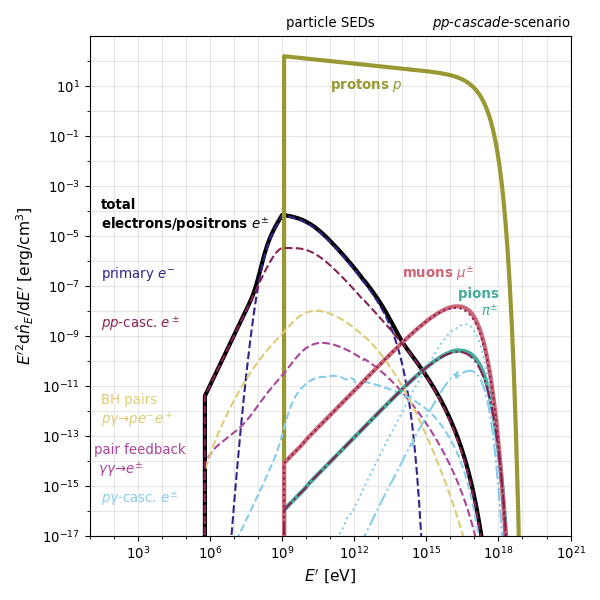

In [10]:

fig, ax = plt.subplots(figsize=(6,6))

ax.loglog(Ee_eV, Ee_erg*am3.get_pairs(), c="k", lw=3)
ax.loglog(Ee_eV, Ee_erg*am3.get_pairs_injected(), c=compcols["in"], ls="--")

ax.loglog(Ep_eV, Ep_erg*am3.get_protons(), c=compcols["p"], lw=3)


ax.loglog(Ee_eV, Ee_erg*am3.get_pairs_annihilation(), c=compcols["pair"], ls="--")

ax.loglog(Ee_eV, Ee_erg*am3.get_pairs_photopion(), c=compcols["pg"], ls="--")
ax.loglog(Ep_eV, Ep_erg*am3.get_pions(), c=compcols["pi"], lw=3)
# ax.loglog(Ep_eV, Ep_erg*am3.get_pion_plus_photopion(), c="r", lw=1)
# ax.loglog(Ep_eV, Ep_erg*am3.get_pion_minus_photopion(), c="k", lw=1, ls="--")
ax.loglog(Ep_eV, Ep_erg*am3.get_pions_photopion(), c=compcols["pg"], ls="-.")
ax.loglog(Ep_eV, Ep_erg*am3.get_muons(), c=compcols["mu"], lw=3)
ax.loglog(Ep_eV, Ep_erg*am3.get_muons_photopion(), c=compcols["pg"], ls=":")

ax.loglog(Ee_eV, Ee_erg*am3.get_pairs_bethe_heitler(), c=compcols["bh"], ls="--")

ax.loglog(Ee_eV, Ee_erg*am3.get_pairs_proton_proton(), c=compcols["pp"], ls="--")    
ax.loglog(Ep_eV, Ep_erg*am3.get_pions_proton_proton(), c=compcols["pp"], ls="-.")
ax.loglog(Ep_eV, Ep_erg*am3.get_muons_proton_proton(), c=compcols["pp"], ls=":")

# ax.loglog(En_eV, En_erg*am3.get_neutrinos(), c="k", lw=3)


ax.text(1e11, 1e1, r"protons $p$", color=compcols["p"], va="center", ha="left", zorder=100, rotation=0, weight="bold")
ax.text(3e1, 6e-5, "total\n" +r"electrons/positrons $e^{\pm}$", color="k", va="center", ha="left", zorder=100, rotation=0, weight="bold")
ax.text(3e1, 3e-7, r"primary $e^{-}$", color=compcols["in"], va="center", ha="left", zorder=100, rotation=0)
ax.text(1.5e1, 1e-14, "pair feedback\n"+ r" $\gamma\gamma \to e^{\pm}$", color=compcols["pair"], va="center", ha="left", zorder=100, rotation=0)
ax.text(3e1, 3e-9, r"$pp$-casc. $e^\pm$", color=compcols["pp"], va="center", ha="left", zorder=100, rotation=0)
ax.text(3e1, 1e-12, "BH pairs\n"+r"$p\gamma\to p e^{-}e^+$", color=compcols["bh"], va="center", ha="left", zorder=100, rotation=0)
ax.text(3e1, 3e-16, r"$p\gamma$-casc. $e^{\pm}$", color=compcols["pg"], va="center", ha="left", zorder=100, rotation=0)

ax.text(2e16, 2e-8, "pions  \n"+r"     $\pi^{\pm}$", color=compcols["pi"], va="center", ha="left", zorder=100, rotation=0, weight="bold")
# ax.text(1e15, 1e-8, r"$p\gamma$-casc.", color=compcols["pg"], va="center", ha="center", zorder=100, rotation=0)
# ax.annotate(r"$p\gamma$-casc.", xy=(1e17, 3e-8), xytext=(1e13, 3e-8), color=compcols["pg"],
#             arrowprops=dict(color=compcols["pg"], arrowstyle="->"))
# ax.annotate(r"$p\gamma$-casc.", xy=(5e17, 2e-9), xytext=(1e13, 3e-8), color=compcols["pg"],
#             arrowprops=dict(color=compcols["pg"], arrowstyle="->"))

# ax.text(1e12, 3e-19, r"$p\gamma$-casc. $\pi^{\pm}$", color=compcols["pg"], va="center", ha="left", zorder=100, rotation=63)

ax.text(1e14, 3e-7, r"muons $\mu^{\pm}$", color=compcols["mu"], va="center", ha="left", zorder=100, rotation=0, weight="bold")
# ax.text(1e11, 3e-19, r"$p\gamma$-casc. $\mu^{\pm}$", color=compcols["pg"], va="center", ha="left", zorder=100, rotation=63)
# ax.annotate(r"$pp$-casc.", xy=(3e15, 3e-12), xytext=(2e13, 3e-10), color=compcols["pp"],
#             arrowprops=dict(color=compcols["pp"], arrowstyle="->"))
# ax.annotate(r"$pp$-casc.", xy=(2e17, 2e-12), xytext=(2e13, 3e-10), color=compcols["pp"],
#             arrowprops=dict(color=compcols["pp"], arrowstyle="->"))

ax.set_title("particle SEDs")
ax.set_title(r"$pp$-$cascade$-scenario", loc="right")
ax.grid(alpha=0.3, which="both")
ax.set_ylim(1e-17, 1e3)
ax.set_yticks(10**np.arange(-17, 3., 2))
ax.set_yticks(10**np.arange(-17, 3., 1), minor=True)
ax.set_yticklabels(["" for i in np.arange(-17, 3., 1)], minor=True)
ax.set_xlim(1e1, 1e21)
ax.set_xticks(10**np.arange(3, 21.5, 3))
ax.set_xticks(10**np.arange(1, 21., 1), minor=True)
ax.set_xticklabels(["" for i in np.arange(1, 21., 1)], minor=True)
ax.set_xlabel(r"$E'$ [eV]")
ax.set_ylabel(r"$E'^2 \mathrm{d} \hat{n}_E/\mathrm{d} E'$ [erg/cm$^3$]")
fig.tight_layout()
sfc.saveFigure(fig, f"pp-cascade-spectrum-particles", dpi=500)